# Setup
in enrich summary, addded Rev_per_dist

In [1]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from scipy.stats import sem
import os
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl

plt.style.use('ggplot')
%matplotlib inline


# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

taxi_file_names = {
    "2018_01": 'datasets/yellow_tripdata_2018-01.csv'
}
taxi_zone_lkup_csv='datasets/taxi_zone_lookup.csv'

In [2]:
def retrieve_summary(zone_lkup_file, taxi_file_names, gb_field):
    taxi_zone_lkup_df = pd.read_csv(taxi_zone_lkup_csv)
    # chunk_list = []  # append each chunk df here     
    gb_field_list = ["trip_count","total_revenue","total_time_min","total_miles"]

    gb_final_file_df = pd.DataFrame()

    for file_key in taxi_file_names: 
        clean_file_df = clean_file(taxi_file_names[file_key], taxi_zone_lkup_df, file_key, gb_field)
        gb_clean_file_df = groupby(clean_file_df, gb_field, gb_field_list)
        gb_final_file_df = gb_final_file_df.append(gb_clean_file_df)
        print(file_key)

    gb_final_file_df = groupby(gb_final_file_df, gb_field, gb_field_list)
    gb_final_file_df = enrich_summary(gb_final_file_df)
    
    return gb_final_file_df

#gives averages (after sum levels have been added)
def enrich_summary(df):
    new_df = df
    new_df['avg_min_ptrip'] = new_df['total_time_min']/new_df['trip_count']
    new_df['avg_dist_ptrip'] = new_df['total_miles']/new_df['trip_count']
    new_df['avg_rev_ptrip'] = new_df['total_revenue']/new_df['trip_count']
    
    new_df['avg_dist_pmin'] = new_df['total_miles']/new_df['total_time_min']
    new_df['avg_rev_pmin'] = new_df['total_revenue']/new_df['total_time_min']
    
    #Teresa's addition
    new_df['rev_per_dist'] = new_df['total_revenue']/new_df['total_miles']

    return new_df


def clean_file(csv, taxi_zone_lkup_df, file_key, gb_field):
    
    chunks_df = pd.read_csv(csv, chunksize=1000000)    
    gb_field_list = ["PULocationID","total_amount","trip_time_min","trip_distance"]
    
    new_gb_df = pd.DataFrame()    
    
    for chunk_df in chunks_df:  
        clean_chunk_df = clean_chunk(chunk_df, taxi_zone_lkup_df, file_key)
        gb_clean_chunk_df = groupby(clean_chunk_df, gb_field, gb_field_list)
        # Once the data filtering is done, append the chunk to list
        new_gb_df = new_gb_df.append(gb_clean_chunk_df)
    return new_gb_df


def clean_chunk(df, zone_lkup_df, file_key):
    new_df = remove_unwanted_columns(df)
    new_df = remove_unwanted_rows(new_df, file_key)
    new_df = add_new_columns(new_df, zone_lkup_df)
    return new_df

def remove_unwanted_columns(df):
    new_df = df.drop(['VendorID', 'store_and_fwd_flag','fare_amount',
                    'extra', 'mta_tax','tolls_amount',
                    'improvement_surcharge'], axis=1) 
    return new_df

def remove_unwanted_rows(df, file_key):
    new_df = df 
    new_df['year'] = pd.DatetimeIndex(new_df['tpep_pickup_datetime']).year
    new_df['month'] = pd.DatetimeIndex(new_df['tpep_pickup_datetime']).month
    
    file_month = file_key.split("_")[1]
    file_year = file_key.split("_")[0] 

    new_df = new_df.loc[(new_df["month"] == float(file_month)) & 
                        (new_df["year"] == float(file_year)), :]

#     new_df = df.drop(['year', 'month'], axis=1)    

    return new_df

def add_new_columns(df, zone_lkup_df):
    #set convert lkup_df to dictionary to leverage 'map' method
    taxi_zone_dic = pd.Series(zone_lkup_df.Zone.values, index=zone_lkup_df.LocationID).to_dict()

    new_df = df
    #create 2 columns for zone_name
    new_df['PU_zone_name'] = new_df.PULocationID.map(taxi_zone_dic)
    new_df['DO_zone_name'] = new_df.DOLocationID.map(taxi_zone_dic)

    #create 2 columns for time
    new_df['trip_time'] = pd.to_datetime(new_df["tpep_dropoff_datetime"]) - pd.to_datetime(new_df["tpep_pickup_datetime"])
    new_df['trip_time_min'] = new_df['trip_time'].dt.total_seconds()/60
    
    new_df['day_of_week'] = pd.to_datetime(new_df["tpep_pickup_datetime"]).dt.day_name()
    new_df['hour_of_day'] = pd.to_datetime(new_df["tpep_pickup_datetime"]).dt.hour
    
    
    return new_df

# used in chunking phase and final summary phase
def groupby(df, gb_field_name, fields):
    groupby = df.groupby([gb_field_name])
    gb_trip_rev_total = groupby[fields[1]].sum()
    gb_trip_time_total = groupby[fields[2]].sum()
    gb_trip_miles_total = groupby[fields[3]].sum()
    
    if fields[0] == 'trip_count':
        gb_trip_count = groupby[fields[0]].sum()
    else:
        gb_trip_count = groupby[fields[0]].count()
        
    new_df = pd.DataFrame({"trip_count": gb_trip_count,
                          "total_revenue": gb_trip_rev_total,
                          "total_time_min": gb_trip_time_total,
                          "total_miles": gb_trip_miles_total})
    
    return new_df

# Create DFs grouped by PU zone and DO zone

In [3]:
#################
'variable names'
#################
'PU_zone_name'
'month'    
'day_of_week'
'hour_of_day'    
'RatecodeID'     
#################

#start = datetime.datetime.today()
# key_variables['PU_zone_name','month','day_of_week','hour_of_day','RatecodeID'] 
#retrieves a summary from a years worth of data for a given variable
do_zone_df = retrieve_summary(taxi_zone_lkup_csv, taxi_file_names, "DO_zone_name")

#end = datetime.datetime.today()
do_zone_df

2018_01


,trip_count,total_revenue,total_time_min,total_miles,avg_min_ptrip,avg_dist_ptrip,avg_rev_ptrip,avg_dist_pmin,avg_rev_pmin,rev_per_dist
DO_zone_name,,,,,,,,,,
Allerton/Pelham Gardens,515,2.381499e+04,1.747453e+04,7007.15,33.931133,13.606117,46.242699,0.400992,1.362840,3.398670
Alphabet City,42567,5.748700e+05,6.504890e+05,98339.48,15.281532,2.310228,13.505062,0.151178,0.883751,5.845770
Arden Heights,55,5.470540e+03,2.504650e+03,1393.38,45.539091,25.334182,99.464364,0.556317,2.184153,3.926093
Arrochar/Fort Wadsworth,167,9.958470e+03,7.482300e+03,2196.59,44.804192,13.153234,59.631557,0.293571,1.330937,4.533604
Astoria,38218,7.691169e+05,7.618286e+05,172579.02,19.933764,4.515648,20.124468,0.226533,1.009567,4.456607
Astoria Park,130,2.799920e+03,2.286517e+03,664.19,17.588590,5.109154,21.537846,0.290481,1.224535,4.215541
Auburndale,450,1.772518e+04,1.577405e+04,5140.28,35.053444,11.422844,39.389289,0.325869,1.123692,3.448291
Baisley Park,3086,7.097550e+04,5.880647e+04,17618.90,19.055887,5.709300,22.999190,0.299608,1.206934,4.028373
Bath Beach,619,2.837025e+04,2.216167e+04,8345.43,35.802369,13.482116,45.832391,0.376571,1.280150,3.399495


In [4]:
pu_zone_df = retrieve_summary(taxi_zone_lkup_csv, taxi_file_names, "PU_zone_name")
pu_zone_df

2018_01


,trip_count,total_revenue,total_time_min,total_miles,avg_min_ptrip,avg_dist_ptrip,avg_rev_ptrip,avg_dist_pmin,avg_rev_pmin,rev_per_dist
PU_zone_name,,,,,,,,,,
Allerton/Pelham Gardens,37,7.076100e+02,5.375833e+02,183.16,14.529279,4.950270,19.124595,0.340710,1.316280,3.863344
Alphabet City,19656,2.740243e+05,2.858902e+05,49099.94,14.544681,2.497962,13.941002,0.171744,0.958495,5.580951
Arden Heights,2,2.217600e+02,5.833333e-01,0.00,0.291667,0.000000,110.880000,0.000000,380.160000,inf
Arrochar/Fort Wadsworth,51,1.508050e+03,4.253000e+02,140.19,8.339216,2.748824,29.569608,0.329626,3.545850,10.757187
Astoria,14673,1.888605e+05,2.031910e+05,36687.68,13.847954,2.500353,12.871296,0.180558,0.929473,5.147792
Astoria Park,71,2.986610e+03,1.162150e+03,373.13,16.368310,5.255352,42.064930,0.321069,2.569901,8.004208
Auburndale,46,9.376000e+02,7.025833e+02,227.28,15.273551,4.940870,20.382609,0.323492,1.334504,4.125308
Baisley Park,2079,1.299668e+05,9.324672e+04,29573.19,44.851716,14.224719,62.514098,0.317150,1.393795,4.394751
Bath Beach,63,1.493400e+03,2.439533e+03,288.67,38.722751,4.582063,23.704762,0.118330,0.612166,5.173381


In [72]:
# grab most important columns for plotting and sort by revenue per minute
preview_df=pu_zone_df[['trip_count','total_time_min','total_miles','avg_rev_pmin','rev_per_dist']]
preview_df.sort_values(by='avg_rev_pmin',ascending=False).head(7)

,trip_count,total_time_min,total_miles,avg_rev_pmin,rev_per_dist
PU_zone_name,,,,,
Charleston/Tottenville,1,0.066667,0.00,1347.000000,inf
Arden Heights,2,0.583333,0.00,380.160000,inf
Port Richmond,2,2.533333,19.40,23.751316,3.101546
Great Kills,7,32.283333,6.80,14.809499,70.308824
Newark Airport,571,3490.300000,1267.72,14.429095,39.726335
Oakwood,2,13.183333,3.90,12.072819,40.810256
City Island,3,12.933333,5.00,7.844072,20.290000


First two rows are bad data, since the total time is a fraction of a minute, and the avg revenue is really high 

In [73]:
#check if we have the same problem with DO zone
do_zone_df.sort_values(by='avg_rev_pmin',ascending=False).head(5)

,trip_count,total_revenue,total_time_min,total_miles,avg_min_ptrip,avg_dist_ptrip,avg_rev_ptrip,avg_dist_pmin,avg_rev_pmin,rev_per_dist
DO_zone_name,,,,,,,,,,
Rossville/Woodrow,35,3767.55,1724.716667,1000.42,49.277619,28.583429,107.644286,0.580049,2.184446,3.765968
Arden Heights,55,5470.54,2504.650000,1393.38,45.539091,25.334182,99.464364,0.556317,2.184153,3.926093
Newark Airport,14042,1356244.88,640445.766667,242969.79,45.609298,17.303076,96.584880,0.379376,2.117658,5.581949
Westerleigh,85,6324.92,3013.466667,1553.72,35.452549,18.279059,74.410824,0.515592,2.098885,4.070824
South Beach/Dongan Hills,147,10798.70,5341.250000,2643.54,36.335034,17.983265,73.460544,0.494929,2.021755,4.084939


In [74]:
#To mitigate skewed "average revenue" datapoints, only pull in pu_zones that have trip counts above a threshold
#use summary statistics to see what would be a reasonable threshold
pu_zone_df['trip_count'].describe()

count       257.000000
mean      34068.929961
std       76999.482334
min           1.000000
25%          68.000000
50%         310.000000
75%        8827.000000
max      360976.000000
Name: trip_count, dtype: float64

In [75]:
#filter by trip_count > 100 per zone -- chose 100 so that most of the data can be captured even with threshold
over_100_pickups = pu_zone_df[pu_zone_df['trip_count']>100]
over_100_pickups.sort_values(by='avg_rev_pmin',ascending=False).head(7)

#get the top5 dropoff locations based on revenue per minute, revenue per distance
pu_top5_revpmin = over_100_pickups.sort_values(by=['avg_rev_pmin'],ascending=False).reset_index().head(5)
pu_top5_revpdist = over_100_pickups.sort_values(by='rev_per_dist',ascending=False).reset_index().head(5)


In [76]:
#filter by trip_count > 100 per zone
over_100_dropoffs = do_zone_df[do_zone_df['trip_count']>100]
over_100_dropoffs= over_100_dropoffs[['trip_count','total_time_min','total_miles','avg_rev_pmin','rev_per_dist']]

#get the top5 dropoff locations based on revenue per minute, revenue per distance
do_top5_revpmin = over_100_dropoffs.sort_values(by=['avg_rev_pmin'],ascending=False).reset_index().head(5)
do_top5_revpdist = over_100_dropoffs.sort_values(by='rev_per_dist',ascending=False).reset_index().head(5)


In [42]:
do_top5_revpmin

,DO_zone_name,trip_count,total_time_min,total_miles,avg_rev_pmin,rev_per_dist
0,Newark Airport,14042,640445.766667,242969.79,2.117658,5.581949
1,South Beach/Dongan Hills,147,5341.250000,2643.54,2.021755,4.084939
2,Bloomfield/Emerson Hill,164,6773.800000,3533.28,2.008728,3.851017
3,Stapleton,150,5685.550000,2724.11,1.893817,3.952627
4,Bellerose,464,11528.650000,5231.59,1.555495,3.427784


In [77]:
pu_top5_revpmin

,PU_zone_name,trip_count,total_revenue,total_time_min,total_miles,avg_min_ptrip,avg_dist_ptrip,avg_rev_ptrip,avg_dist_pmin,avg_rev_pmin,rev_per_dist
0,Newark Airport,571,50361.87,3490.300000,1267.72,6.112609,2.220175,88.199422,0.363212,14.429095,39.726335
1,Randalls Island,258,15579.25,5242.266667,1748.84,20.318863,6.778450,60.384690,0.333604,2.971854,8.908334
2,Richmond Hill,310,9436.24,4344.150000,1416.16,14.013387,4.568258,30.439484,0.325992,2.172172,6.663258
3,Corona,322,12392.83,5767.383333,1855.81,17.911128,5.763385,38.487050,0.321777,2.148779,6.677855
4,South Ozone Park,693,36990.77,18309.083333,5927.92,26.420034,8.553997,53.377734,0.323769,2.020351,6.240093


# Create basic plots (in case heat map doesn't work out)

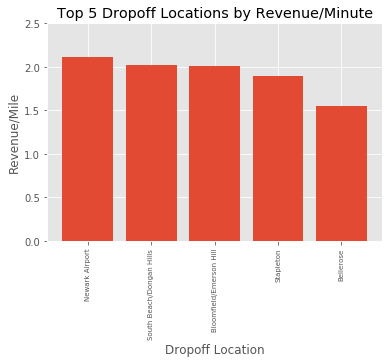

In [84]:
x = do_top5_revpmin.DO_zone_name
y = do_top5_revpmin.avg_rev_pmin
yticks=[0,0.5,1,1.5,2,2.5]

fig=plt.bar(x,y)
plt.xlabel('Dropoff Location')
plt.ylabel('Revenue/Mile' )
plt.title('Top 5 Dropoff Locations by Revenue/Minute')
plt.tick_params(axis='x', which='major', labelsize=7)
plt.yticks(yticks)
plt.xticks(rotation=90)

#plt.tight_layout()


plt.show()

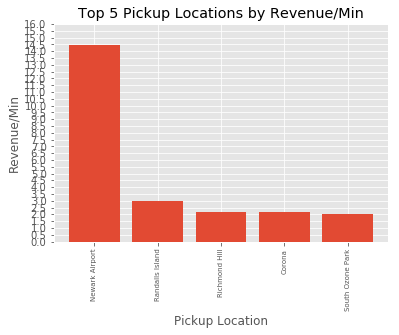

In [81]:
x = pu_top5_revpmin.PU_zone_name
y = pu_top5_revpmin.avg_rev_pmin
yticks=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16]

fig=plt.bar(x,y)
plt.xlabel('Pickup Location')
plt.ylabel('Revenue/Min' )
plt.title('Top 5 Pickup Locations by Revenue/Min')
plt.tick_params(axis='x', which='major', labelsize=7)
plt.yticks(yticks)
plt.xticks(rotation=90)

#plt.tight_layout()


plt.show()

# Try to make a heatmap based on taxi_zone shapefile
Referenced another project: https://chih-ling-hsu.github.io/2018/05/14/NYC#location-data

In [10]:
#taxi_zones_df = pd.read_csv('datasets/taxi_zones_shape.csv')
#zone_cols = taxi_zones_df.columns.tolist()
#zone_cols = ['LocationID','OBJECTID','Shape_Area','Shape_Leng','zone','borough','X','Y']
#taxi_zones_df = taxi_zones_df[zone_cols].rename(columns=['X':''])
#taxi_zones_df

SyntaxError: invalid syntax (<ipython-input-10-5cf58efec46c>, line 4)

In [9]:
taxi_zone_lkup_df = pd.read_csv(taxi_zone_lkup_csv)
#taxi_zone_dic = pd.Series([taxi_zone_lkup_df.Zone.values, taxi_zone_lkup_df., index=taxi_zone_lkup_df.LocationID).to_dict()
taxi_zone_lkup_df

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
5,6,Staten Island,Arrochar/Fort Wadsworth,Boro Zone
6,7,Queens,Astoria,Boro Zone
7,8,Queens,Astoria Park,Boro Zone
8,9,Queens,Auburndale,Boro Zone
9,10,Queens,Baisley Park,Boro Zone


In [11]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [12]:
sf = shapefile.Reader("shape/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

,LocationID,OBJECTID,Shape_Area,Shape_Leng,borough,zone,longitude,latitude
0,1,1,0.000782,0.116357,EWR,Newark Airport,9.366817e+05,190522.130278
1,2,2,0.004866,0.433470,Queens,Jamaica Bay,1.033536e+06,161853.982300
2,3,3,0.000314,0.084341,Bronx,Allerton/Pelham Gardens,1.027136e+06,254730.010849
3,4,4,0.000112,0.043567,Manhattan,Alphabet City,9.904240e+05,203100.040432
4,5,5,0.000498,0.092146,Staten Island,Arden Heights,9.321332e+05,139954.541936


In [17]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max
def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])
    
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

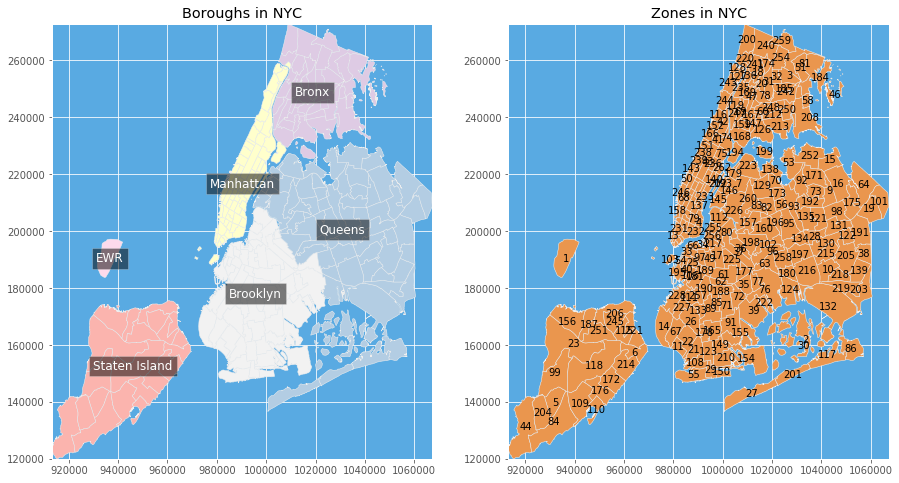

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

In [ ]:
#PU regions with highest rev/min

,index,DO_zone_name,trip_count,total_time_min,total_miles,avg_rev_pmin,rev_per_dist
0,0,Saint Michaels Cemetery/Woodside,398,2.800283e+03,370.47,1.246185,9.419575
1,1,Upper East Side South,320236,3.975148e+06,511702.47,0.917107,7.124528
2,2,Penn Station/Madison Sq West,221457,3.435306e+06,409658.75,0.837031,7.019154
3,3,Union Sq,245733,3.278343e+06,440644.72,0.921617,6.856719
4,4,Garment District,134869,2.192879e+06,276715.74,0.855092,6.776316


In [ ]:
#example code
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most pickups")
draw_zone_map(ax, sf, heat=PUcount, text=PUtop3.index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones with most drop-offs")
draw_zone_map(ax, sf, heat=DOcount, text=DOtop3.index.tolist())

In [ ]:
#example code
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
ax = plt.subplot(2, 2, 1)
ax.set_title("Zones with most pickups for Short Trips")
draw_zone_map(ax, sf, heat=PUcount_short, text=PUtop3_short.index.tolist())
ax = plt.subplot(2, 2, 2)
ax.set_title("Zones with most pickups for Long Trips")
draw_zone_map(ax, sf, heat=PUcount_long, text=PUtop3_long.index.tolist())
ax = plt.subplot(2, 2, 3)
ax.set_title("Zones with most drop-offs for Short Trips")
draw_zone_map(ax, sf, heat=DOcount_short, text=DOtop3_short.index.tolist())
ax = plt.subplot(2, 2, 4)
ax.set_title("Zones with most drop-offs for Long Trips")
draw_zone_map(ax, sf, heat=DOcount_long, text=DOtop3_long.index.tolist())